# Reconnaissance du locuteur (Chirac/Mitterrand)

### SOYKOK Aylin 28711545 - CELIK Simay 28713301 </b>

## Analyse des données et des prétraitements

<b>
Ce notebook était créé afin de : <br>
    -se familiariser avec les données <br>
    -se familiariser avec des pretraitements <br>
    -se familiariser avec des N-grammes <br>
    -tester des pretraitements et des N-grammes 1 par 1 <br>
</b>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import codecs
import re
import os.path
import string
import nltk
from nltk.stem.snowball import FrenchStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from utils_donnee import *
from evaluation import *
# Chargement des données
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = load_pres(fname)

## Se familiariser avec les données

In [4]:
print(f'Taille texts : {len(alltxts)}, taille labels {len(alllabs)}')
print("Un exemple de text et son label")
print(alltxts[0])
print(alllabs[0])
print("\nUn autre exemple de text et son label")
print(alltxts[-1])
print(alllabs[-1])

Taille texts : 57413, taille labels 57413
Un exemple de text et son label
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1

Un autre exemple de text et son label
 Je compte sur vous.

1


<b> Donc dans cette partie du projet, nous allons essayer d'estimer le locuteur d'une phrase. On a une base de trainage où y se trouve 57000 d'exemples de phrases avec les labels indiquant le locuteur. Le but est de trouver les meilleures méthodes d'apprentissage sur cette base, de les appliquer afin de voir si on peut qui a dit quoi à partir de leurs façons de parler grâce au modèle BoW. 

### Distribution des labels

Il y a 2 classes afin de classifier les locuteurs: <br>
classe 1: Chirac <br>
classe -1: Miterrand

In [5]:
count_chirac = alllabs.count(1)
count_mitterrand = alllabs.count(-1)
print("Nombre de labels Chirac:", count_chirac)
print("Nombre de labels Mitterrand:", count_mitterrand)

Nombre de labels Chirac: 49890
Nombre de labels Mitterrand: 7523


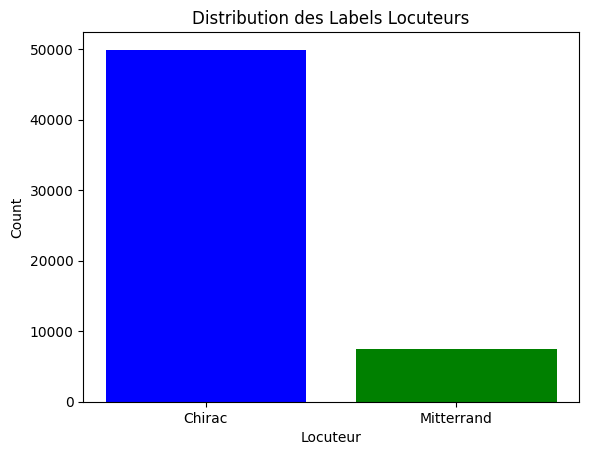

In [6]:
# Visualisation avec un histogramme

labels = ['Chirac', 'Mitterrand']
counts = [count_chirac, count_mitterrand]

plt.bar(labels, counts, color=['blue', 'green'])
plt.xlabel('Locuteur')
plt.ylabel('Count')
plt.title('Distribution des Labels Locuteurs')
plt.show()

<b> On voit que les labels sont déséquilibrés. Il y a beaucoup de Chirac et peu de Miterrand. </b>

# A) Transformation paramétrique du texte (pre-traitements)

<b> Dans cette partie, on appliquera différents types de pre-traitement et décider lesquels peuvent nous servir au cours d'apprentissage.

### suppression de la ponctuation

In [7]:
# test
example = alltxts[0]
example_no_ponc = ponc_suppression(example)
print("Texte originale:")
print(example)
print("\nTexte après suppression de la ponctuation:")
print(example_no_ponc)

Texte originale:
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.


Texte après suppression de la ponctuation:
 Quand je dis chers amis  il ne s agit pas là d une formule diplomatique  mais de l expression de ce que je ressens  


<b> La suppression de la ponctuation nous servira car si on les supprime pas, ils seront comptés comme des mots et satureront la méthode BoW.

### suppression des lettres majuscules

In [8]:
# test
example = alltxts[38]
example_no_upper = uppercase_suppression(example)
print("Texte originale:")
print(example)
print("\nTexte après suppression des lettres majuscules:")
print(example_no_upper)

Texte originale:
 Je lève mon verre en l'honneur du <nom> , Président de la République du Congo, en l'honneur de <nom> , en l'honneur du Congo ami de la France.


Texte après suppression des lettres majuscules:
 je lève mon verre en l'honneur du <nom> , président de la république du congo, en l'honneur de <nom> , en l'honneur du congo ami de la france.



<b> Ici on voit la différence d'une phrase avec la suppression des lettres majuscules et sans. On peut ne pas faire de transformation en minuscule car il y a des noms propres. Ici, le mot "république" était dans un nom propre donc si on supprime le premier lettre en majuscule, il seta compté avec toutes les autres occurences du mot "république". On le testera dans la suite.

### suppression chiffres

In [9]:
# test
example = alltxts[1336]
example_no_chiffre = chiffre_suppression(example)
print("Texte originale:")
print(example)
print("\nTexte après suppression des chiffres:")
print(example_no_chiffre)

Texte originale:
 Un ancien chef de gouvernement observait il y a quelques jours, que sous la législature précédente, il y avait 10000 chômeurs de plus par moi, ce qui n'était pas fameux.


Texte après suppression des chiffres:
 Un ancien chef de gouvernement observait il y a quelques jours, que sous la législature précédente, il y avait  chômeurs de plus par moi, ce qui n'était pas fameux.



<b> L'utilisation des chiffres peuvent indiquer le locuteur mais si cette indication n'est pas assez forte, alors elle peut encore une fois saturer BoW.

### transformation des mots entièrement en majuscule en marqueurs spécifiques

In [10]:
# test
text = ponc_suppression(alltxts[2467]) # on supprime la ponctuation d'abord car sinon il donne une erreur
marker = "<UPPER>"
new_text = transform_uppercase(text, marker)
print("Texte originale:")
print(text)
print("Texte après transformation:")
print(new_text)

Texte originale:
 Les études de l OMS et de l ONUSIDA le démontrent   l épidémie s étend  en Asie  en Russie  dans les pays de la CEI  dans les pays d Europe centrale et orientale  
Texte après transformation:
Les études de l <UPPER> et de l <UPPER> le démontrent l épidémie s étend en Asie en Russie dans les pays de la <UPPER> dans les pays d Europe centrale et orientale


<b> Ici, on a un context diplomatique donc il y a des nombreux exemples d'abbreviations. On peut utiliser des marqueurs.

### suppression des balises

In [11]:
# test
# on trouve les numéros des lignes qui contiennent des balises
lines_with_tags = find_lines_with_tags(alltxts)
print(f'Nombre de lignes avec tags : {len(lines_with_tags)}')

Nombre de lignes avec tags : 3938


In [12]:
text_balise = alltxts[38]
sans_balise = remove_tags(text_balise)
print("Texte originale:")
print(text_balise)
print("Texte après transformation:")
print(sans_balise)

Texte originale:
 Je lève mon verre en l'honneur du <nom> , Président de la République du Congo, en l'honneur de <nom> , en l'honneur du Congo ami de la France.

Texte après transformation:
 Je lève mon verre en l'honneur du  , Président de la République du Congo, en l'honneur de  , en l'honneur du Congo ami de la France.



In [13]:
text_balise2 = alltxts[132]
sans_balise2 = remove_tags(text_balise2)
print("Texte originale:")
print(text_balise2)
print("Texte après transformation:")
print(sans_balise2)

Texte originale:
 Nous sommes convenus d'organiser, en <date>, une "Année du Maroc" en France, série de grandes manifestations culturelles et technologiques, qui permettra de mieux faire connaître le Maroc, ses traditions, mais aussi sa modernité dans toutes les villes de notre pays.

Texte après transformation:
 Nous sommes convenus d'organiser, en , une "Année du Maroc" en France, série de grandes manifestations culturelles et technologiques, qui permettra de mieux faire connaître le Maroc, ses traditions, mais aussi sa modernité dans toutes les villes de notre pays.



<b> Sans faire des tests, on peut remarquer que la suppression des balises peut nous servir car ils mettent pas de contexte humain aux phrases.

### stemming

In [14]:
# test
text_test = alltxts[840]
stemmed = stem(text_test)
print("Texte originale:")
print(text_test)
print("Texte après stemmatisation:")
print(stemmed)

Texte originale:
 La lumière y est plus vive ".

Texte après stemmatisation:
la lumi y est plus viv `` .


In [15]:
text_test = alltxts[1823]
stemmed = stem(text_test)
print("Texte originale:")
print(text_test)
print("Texte après stemmatisation:")
print(stemmed)

Texte originale:
 D'ambition pour elle-même, d'ambition pour le monde.

Texte après stemmatisation:
d'ambit pour elle-mêm , d'ambit pour le mond .


<b> Stemming est une méthode très utile de pretraitement car plusieurs mots ont une racine commune et avec stemming, on les compte comme un seul mot.

### suppression des accents

In [16]:
# test
example = alltxts[1336]
example_no_accent =  accent_suppression(example)
print("Texte originale:")
print(example)
print("\nTexte après suppression des accents:")
print(example_no_accent)

Texte originale:
 Un ancien chef de gouvernement observait il y a quelques jours, que sous la législature précédente, il y avait 10000 chômeurs de plus par moi, ce qui n'était pas fameux.


Texte après suppression des accents:
 Un ancien chef de gouvernement observait il y a quelques jours, que sous la legislature precedente, il y avait 10000 chomeurs de plus par moi, ce qui n'etait pas fameux.



<b> Dans la langue français, il y a beaucoup de mots avec accents. Les accents peuvent ajouter un context à un mot sans perdre la définition principale (comme créer et créé qui est la conjugaison du mot) mais un mot sans son accent peut devenir des homographes (par exemple la et là).

# B) Extraction du vocabulaire (BoW) et N-grammes


### La taille d'origine du vocabulaire sans pre-processing

In [17]:
vectorizer = CountVectorizer() #no preprocessing
X = vectorizer.fit_transform(alltxts)
vocabulary = vectorizer.vocabulary_
print("Taille originale du vocab :",len(vocabulary))

Taille originale du vocab : 28524


### 100 mots les plus fréquents

In [18]:
max_features = 100
vectorizer =  CountVectorizer(max_features=max_features)
X = vectorizer.fit_transform(alltxts)
dic_size = X.shape[1]###

words = vectorizer.get_feature_names_out()
word_freq = dict(zip(words, X.sum(axis=0).A1))
print(dic_size)
print(words)

100
['ai' 'au' 'aujourd' 'aussi' 'autres' 'aux' 'avec' 'avez' 'avons' 'bien'
 'ce' 'cela' 'ces' 'cette' 'ceux' 'chacun' 'comme' 'dans' 'date' 'de'
 'depuis' 'des' 'deux' 'dire' 'doit' 'dont' 'du' 'développement' 'elle'
 'en' 'encore' 'ensemble' 'entre' 'est' 'et' 'etat' 'europe' 'faire'
 'fait' 'faut' 'france' 'français' 'hui' 'ici' 'il' 'ils' 'je' 'la' 'le'
 'les' 'leur' 'leurs' 'mais' 'monde' 'monsieur' 'même' 'ne' 'nom' 'nos'
 'notre' 'nous' 'on' 'ont' 'ou' 'où' 'paix' 'par' 'pas' 'pays' 'peut'
 'plus' 'politique' 'pour' 'président' 'qu' 'que' 'qui' 'sa' 'sans' 'se'
 'ses' 'si' 'son' 'sont' 'sur' 'temps' 'tous' 'tout' 'toute' 'toutes'
 'très' 'un' 'une' 'union' 'vie' 'vos' 'votre' 'vous' 'été' 'être']


<b> Sans aucun pré-traitement, la plupart des mots les plus fréquents sont des prépositions, des conjonctions et des pronoms. On voit aussi 'tous' 'tout' 'toute' 'toutes' qui sont le même mot en différentes formes. Ces problèmes peuvent être résolus avec le stemming et les stopwords.
    
Voici un nuage de mots les plus fréquents.

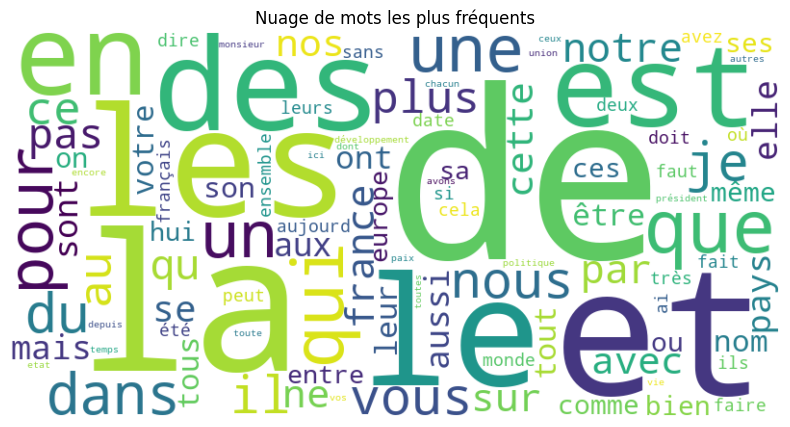

In [19]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots les plus fréquents")
plt.show()

### 100 mots les plus discriminants au sens de odds ratio

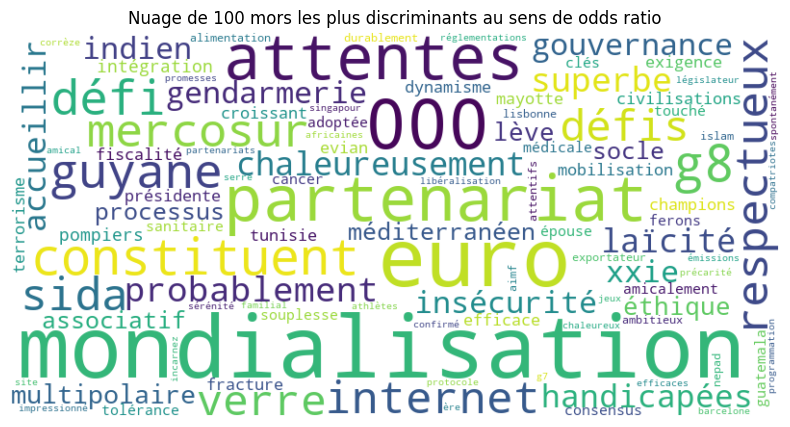

In [20]:
from sklearn.naive_bayes import MultinomialNB
vectorizer = CountVectorizer() # on utilise Count Vectorizer
X = vectorizer.fit_transform(alltxts)
clf = MultinomialNB() # on utilise naive bayes selon la loi multinomiale
clf.fit(X, alllabs)
log_probabilities = clf.feature_log_prob_
odds_ratios = np.exp(log_probabilities[1] - log_probabilities[0])
words = vectorizer.get_feature_names_out()
word_odds_ratios = dict(zip(words, odds_ratios))
sorted_word_odds_ratios = sorted(word_odds_ratios.items(), key=lambda x: x[1], reverse=True)
top_100_words = dict(sorted_word_odds_ratios[:100])
# Afficher le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_100_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de 100 mors les plus discriminants au sens de odds ratio")
plt.show()

<b> Ici, on calcule odds ratio de chaque mot selon la difference de log vraisemblance de ce mot d'appartenir dans la classe positive (1) ou la classe négative (0). Si le taux de cotes est grand, alors il est plus vraisemblant que le mot appartient dans la classe positive. Donc dans ce nuage de mots, on voit les 100 mots les plus discriminatifs entre les classes.

### distribution d'apparition des mots (Zipf)

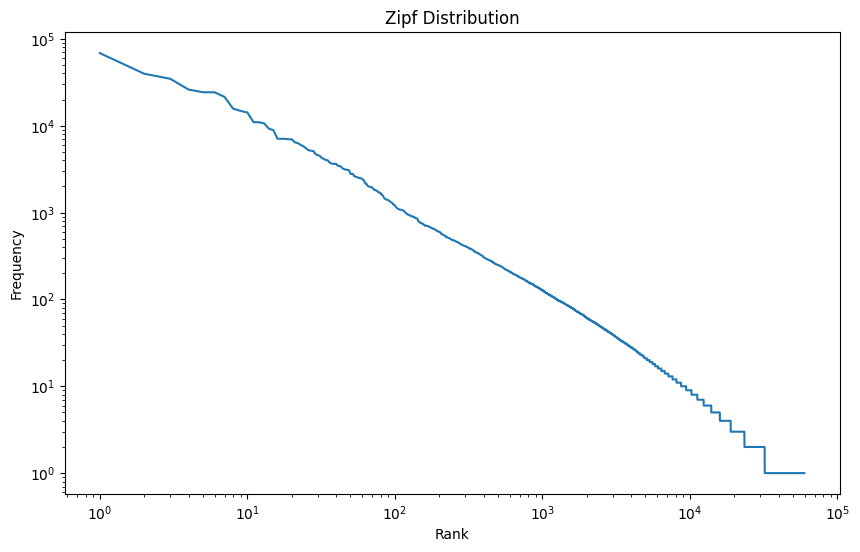

In [21]:
words = [word for text in alltxts for word in text.split()]
word_freq = Counter(words)
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
frequencies = [freq for word, freq in sorted_word_freq]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(frequencies) + 1), frequencies)
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Zipf Distribution')
plt.xscale('log')
plt.yscale('log')
plt.show()

<b> Ici, on observe la loi de Zipf sur les fréquences des mots. Selin cette loi, dans NLP, la fréquence d'un mot est inversement proportionnel à son rang. Donc le n-ième mot le plus fréquent va apparaitre (n+1) fois plus que (n+1)-ième mot. $freq(nb\_occ)=\frac{k}{nb\_occ} $. Ce graphe est cohérent avec celui qu'on a vu dans le cours.

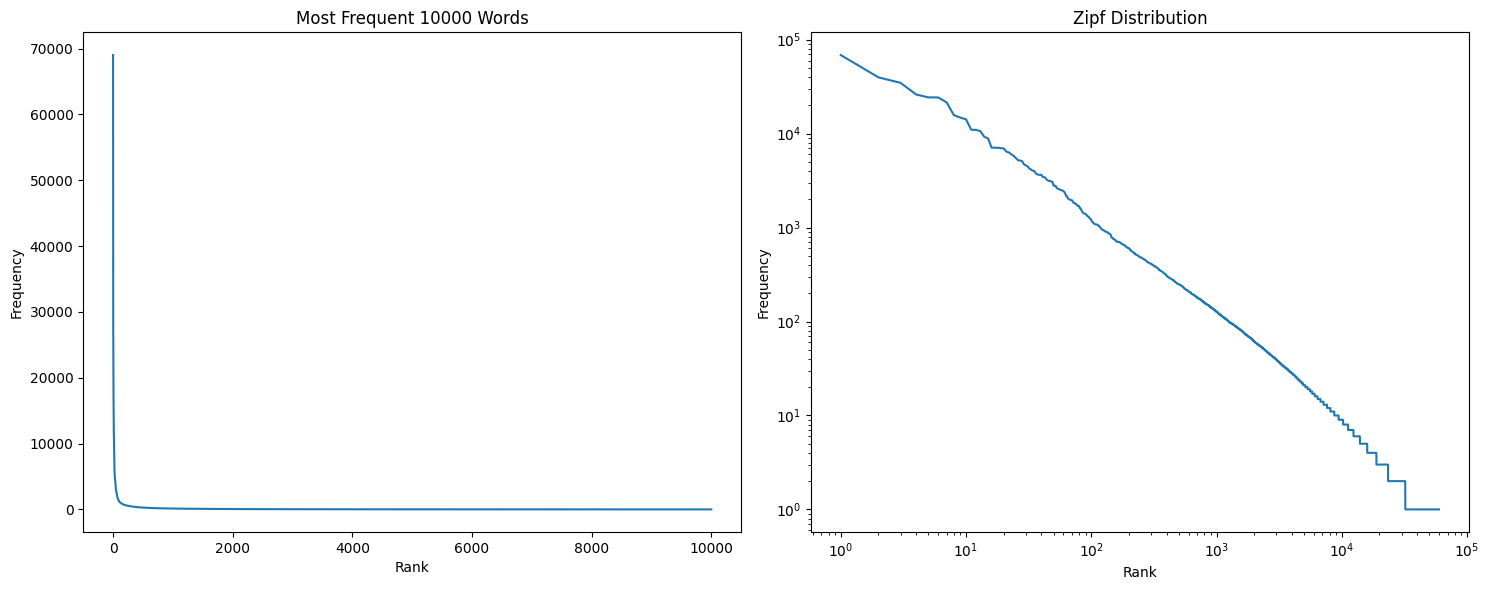

In [22]:
# Most frequent 100000 words vs Zipf Law

max_features = 10000
vectorizer =  CountVectorizer(max_features=max_features)
X = vectorizer.fit_transform(alltxts)
dic_size = X.shape[1]
words = vectorizer.get_feature_names_out()
word_freq = dict(zip(words, X.sum(axis=0).A1))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
words_sorted, frequencies_sorted = zip(*sorted_word_freq)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(range(1, len(words_sorted) + 1), list(frequencies_sorted))
axs[0].set_title('Most Frequent 10000 Words')
axs[0].set_xlabel('Rank')
axs[0].set_ylabel('Frequency')

# Zipf
axs[1].plot(range(1, len(frequencies) + 1), frequencies)
axs[1].set_title('Zipf Distribution')
axs[1].set_xlabel('Rank')
axs[1].set_ylabel('Frequency')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

plt.tight_layout()
plt.show()

<b> On voit que les fréquences des mots suit a loi de Zipf.

### 100 Bigrammes les plus fréquents

In [23]:
ngram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=100)
X_ngrams = ngram_vectorizer.fit_transform(alltxts)
ngram_names = ngram_vectorizer.get_feature_names_out()
ngram_freq = X_ngrams.sum(axis=0).A1

ngram_freq_dict = dict(zip(ngram_names, ngram_freq))
sorted_ngrams = sorted(ngram_freq_dict.items(), key=lambda x: x[1], reverse=True)
top_100_bigrams = dict(sorted_ngrams[:100])
#for ngram, freq in top_100_bigrams:
#    print(f"{ngram}: {freq}")
print(top_100_bigrams)


{'de la': 11951, 'et de': 4385, 'la france': 4091, 'aujourd hui': 2581, 'dans le': 2297, 'et la': 2195, 'qu il': 1983, 'de notre': 1932, 'de nos': 1753, 'il faut': 1722, 'tous les': 1653, 'dans la': 1625, 'et les': 1614, 'que nous': 1610, 'vous avez': 1588, 'monsieur le': 1507, 'que la': 1395, 'dans les': 1361, 'nous avons': 1320, 'que vous': 1304, 'il est': 1276, 'et des': 1269, 'qui est': 1260, 'que les': 1216, 'et le': 1201, 'le président': 1160, 'et je': 1156, 'pour la': 1119, 'est pas': 1108, 'et qui': 1079, 'ce qui': 1065, 'ceux qui': 1044, 'ce que': 1024, 'que je': 1024, 'sur le': 1024, 'qui ont': 1013, 'est un': 993, 'de ce': 969, 'nous devons': 959, 'de votre': 955, 'du monde': 955, 'de cette': 951, 'le monde': 950, 'qu elle': 941, 'sur la': 909, 'par la': 903, 'que le': 899, 'est une': 895, 'pour les': 873, 'de ses': 856, 'je suis': 854, 'est la': 835, 'les plus': 832, 'la paix': 817, 'notre pays': 791, 'qu ils': 789, 'toutes les': 780, 'est le': 777, 'la vie': 764, 'doit êtr

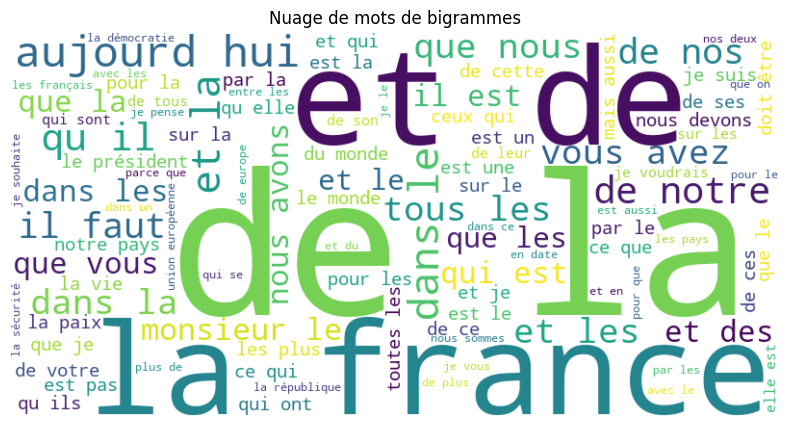

In [24]:
# Afficher le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_100_bigrams)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots de bigrammes")
plt.show()

<b> Voici les 100 bigrammes. La fréquence d'apparition de 'de la' est trop haute que les autres bigrammes.

### 100 trigrammes les plus fréquents

In [25]:
ngram_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=100)
X_ngrams = ngram_vectorizer.fit_transform(alltxts)
ngram_names = ngram_vectorizer.get_feature_names_out()
ngram_freq = X_ngrams.sum(axis=0).A1

ngram_freq_dict = dict(zip(ngram_names, ngram_freq))
sorted_ngrams = sorted(ngram_freq_dict.items(), key=lambda x: x[1], reverse=True)
top_100_trigrams = dict(sorted_ngrams[:100])
#for ngram, freq in top_100_trigrams:
#    print(f"{ngram}: {freq}")
print(top_100_trigrams)


{'de la france': 954, 'monsieur le président': 923, 'et de la': 765, 'dans le monde': 516, 'de la république': 478, 'mesdames et messieurs': 448, 'la france est': 395, 'et la france': 392, 'que la france': 385, 'ce est pas': 380, 'que vous avez': 380, 'de la vie': 373, 'de plus en': 356, 'plus en plus': 355, 'de tous les': 343, 'nos deux pays': 336, 'dans le domaine': 309, 'la france et': 307, 'au service de': 298, 'dans le cadre': 290, 'de la paix': 288, 'de notre pays': 277, 'que nous avons': 277, 'je suis heureux': 265, 'de union européenne': 257, 'ce qui est': 256, 'droits de homme': 247, 'la mise en': 247, 'monsieur le maire': 245, 'je souhaite que': 244, 'tous ceux qui': 242, 'sur le plan': 239, 'la lutte contre': 238, 'de la démocratie': 235, 'vous le savez': 230, 'président de la': 229, 'au sein de': 224, 'entre nos deux': 215, 'ne sont pas': 214, 'de la communauté': 206, 'je sais que': 205, 'le respect de': 205, 'ceux qui ont': 202, 'les moyens de': 201, 'au nom de': 200, 'de 

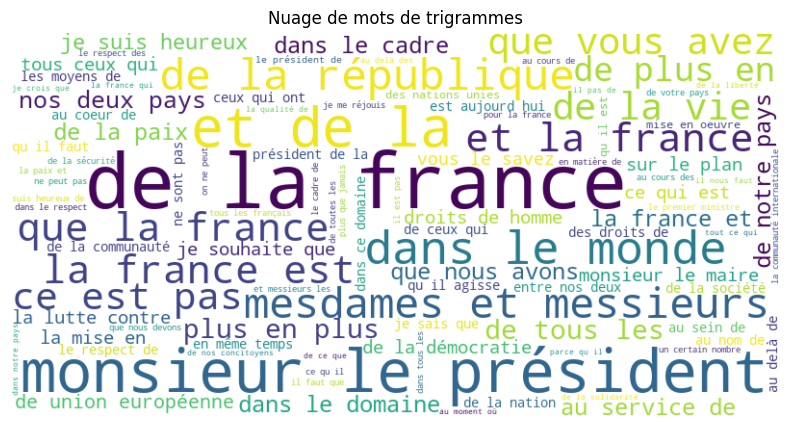

In [26]:
# Afficher le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_100_trigrams)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots de trigrammes")
plt.show()

In [27]:
ngram_vectorizer = CountVectorizer(ngram_range=(4,4), max_features=100)
X_ngrams = ngram_vectorizer.fit_transform(alltxts)
ngram_names = ngram_vectorizer.get_feature_names_out()
ngram_freq = X_ngrams.sum(axis=0).A1

ngram_freq_dict = dict(zip(ngram_names, ngram_freq))
sorted_ngrams = sorted(ngram_freq_dict.items(), key=lambda x: x[1], reverse=True)
top_100_4grams = dict(sorted_ngrams[:100])

print(top_100_4grams)


{'de plus en plus': 355, 'je suis heureux de': 164, 'des droits de homme': 160, 'entre nos deux pays': 154, 'mesdames et messieurs les': 152, 'président de la république': 145, 'dans le cadre de': 126, 'dans le domaine de': 117, 'un certain nombre de': 116, 'le président de la': 113, 'la mise en oeuvre': 109, 'pour la première fois': 103, 'il ne faut pas': 101, 'de la france et': 100, 'au nom de la': 99, 'celles et tous ceux': 99, 'toutes celles et tous': 99, 'dans tous les domaines': 97, 'et tous ceux qui': 96, 'qu il agisse de': 95, 'au service de la': 94, 'celles et ceux qui': 93, 'chacune et chacun entre': 92, 'tout au long de': 92, 'la mise en place': 91, 'et chacun entre vous': 86, 'la lutte contre le': 84, 'le général de gaulle': 83, 'des hommes et des': 82, 'monsieur le premier ministre': 82, 'monsieur le président de': 81, 'de la légion honneur': 78, 'on ne peut pas': 77, 'dans le respect de': 74, 'chefs etat et de': 73, 'etat et de gouvernement': 73, 'il ne agit pas': 73, 'le

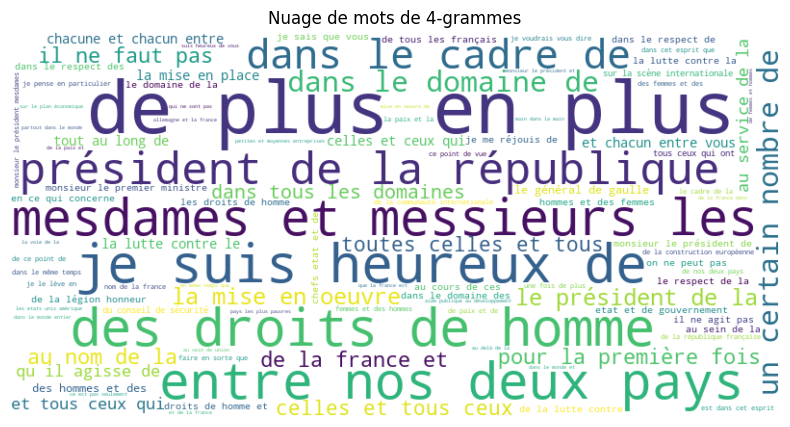

In [28]:
# Afficher le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_100_4grams)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots de 4-grammes")
plt.show()

<b> Les phrases sont complèxes à comprendre car ici, on ne travail pas sur les emotions mais on travail sur tous les caractéristiques des locuteurs. Donc, il vaut mieux d'utiliser des N-grammes.

### Stopwords

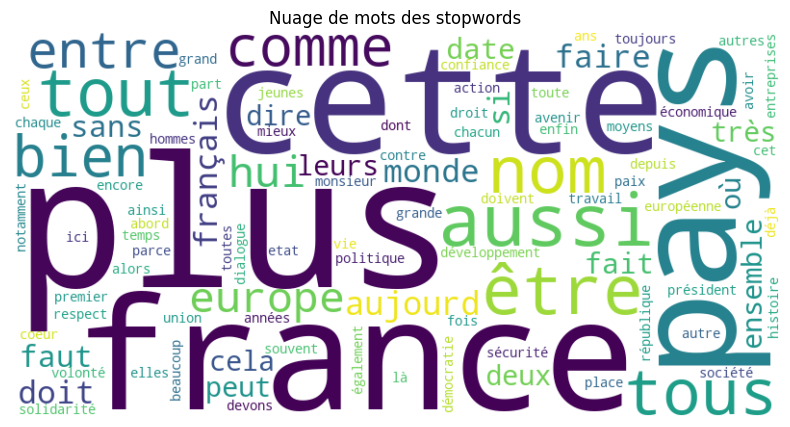

In [29]:
# les 100 mots les plus fréquents après sans considérer les stopwords
#nltk.download('stopwords')
from nltk.corpus import stopwords
max_features = 100
vectorizer = CountVectorizer(max_features=max_features, stop_words=stopwords.words('french'))
X = vectorizer.fit_transform(alltxts)
words = vectorizer.get_feature_names_out()
word_freq = dict(zip(words, X.sum(axis=0).A1))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots des stopwords")
plt.show()

<b> Stopwords sont des mots trop utilisés d'une langue tel qu'ils n'apportent pas de context significatif à un texte. Donc les ignorer peut créer des résultats plus cohérents.

# C) Tests de BoW sur différents pré-traitements  (BoW)

<b> Dans cette partie, on testera des différents pretraitements mentionnés au dessus sans entrer dans détail. L'optimisation des paramètres est faite dans un autre notebook.
    
<b>
Pour chaque moyenne de pretraitement, on a deux variantes : CountVectorizer et TfidfVectorizer sans paramètres. Le but est de voir si les pretraitement sont utiles dans ce contexte et de voir quel vectorizer nous donne des meilleurs résultats.
</b>

### test avec sans aucun pretraitement

In [5]:
# test sans pretraitement
preprocessor = None
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
print("Résultats Tfidf")
tfidf_sans = eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
print("Résultats CountVectorizer")
countv_sans = eval_test(preprocessor=preprocessor, vectorizer=CountVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
res,nb_fois = accuracy_difference(tfidf_sans,countv_sans)

print(f'Nb de fois Tfidf était plus accurate : {nb_fois}')
res

Résultats Tfidf
Accuracy: 0.8923
F1 Score: 0.9391
Precision: 0.9230
ROC AUC sur Mitterrand (minoritaire): 0.1475
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5344
ROC AUC sur Chirac: 0.8525
AP sur Mitterrand (minoritaire): 0.7304
_________________________
Résultats CountVectorizer
Accuracy: 0.8733
F1 Score: 0.9273
Precision: 0.9241
ROC AUC sur Mitterrand (minoritaire): 0.1784
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5049
ROC AUC sur Chirac: 0.8216
AP sur Mitterrand (minoritaire): 0.7394
_________________________
Nb de fois Tfidf était plus accurate : 0.8


[1, 1, 1, 1, 2]

<b> $\frac{4}{5}$ de fois, Tfidf était plus précis.

### test avec suppression de la ponctuation

In [6]:
# test avec suppresion de ponctuation
preprocessor = ponc_suppression
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
print("Résultats Tfidf")
res1 = eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
print("Résultats CountVectorizer")
res2 = eval_test(preprocessor=preprocessor, vectorizer=CountVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
res,nb_fois = accuracy_difference(res1,res2)
print(f'Nb de fois Tfidf était plus accurate : {accuracy_difference(res1,res2)}')
print(f'Nb de fois suppression de la ponctuation était plus accurate : {accuracy_difference(res1,tfidf_sans)}')

Résultats Tfidf
Accuracy: 0.8971
F1 Score: 0.9416
Precision: 0.9283
ROC AUC sur Mitterrand (minoritaire): 0.1296
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5654
ROC AUC sur Chirac: 0.8704
AP sur Mitterrand (minoritaire): 0.7252
_________________________
Résultats CountVectorizer
Accuracy: 0.8780
F1 Score: 0.9300
Precision: 0.9276
ROC AUC sur Mitterrand (minoritaire): 0.1589
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5265
ROC AUC sur Chirac: 0.8411
AP sur Mitterrand (minoritaire): 0.7335
_________________________
Nb de fois Tfidf était plus accurate : ([1, 1, 1, 1, 2], 0.8)
Nb de fois suppression de la ponctuation était plus accurate : ([1, 1, 1, 1, 2], 0.8)


<b> Encore une fois, TfidfVectorizer semble plus précis que CountVectorizer. La suppression de ponctuation a amélioré l'accuracy.

### test avec suppression des chiffres

In [7]:
# test avec suppresion de chiffres
preprocessor = chiffre_suppression
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
print("Résultats Tfidf")
res3 = eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
print("Résultats CountVectorizer")
res4 = eval_test(preprocessor=preprocessor, vectorizer=CountVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
res,nb_fois = accuracy_difference(res3,res4)
print(f'Nb de fois Tfidf était plus accurate : {accuracy_difference(res3,res4)}')
print(f'Nb de fois le prétraitement était plus accurate : {accuracy_difference(res3,tfidf_sans)}')

Résultats Tfidf
Accuracy: 0.8972
F1 Score: 0.9417
Precision: 0.9286
ROC AUC sur Mitterrand (minoritaire): 0.1302
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5668
ROC AUC sur Chirac: 0.8698
AP sur Mitterrand (minoritaire): 0.7254
_________________________
Résultats CountVectorizer
Accuracy: 0.8782
F1 Score: 0.9301
Precision: 0.9274
ROC AUC sur Mitterrand (minoritaire): 0.1587
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5259
ROC AUC sur Chirac: 0.8413
AP sur Mitterrand (minoritaire): 0.7334
_________________________
Nb de fois Tfidf était plus accurate : ([1, 1, 1, 1, 2], 0.8)
Nb de fois le prétraitement était plus accurate : ([1, 1, 1, 1, 2], 0.8)


<b> Encore une fois, la transformation est utile.

### test avec suppression des accents

In [8]:
# test avec suppresion des accents
preprocessor = accent_suppression
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
print("Résultats Tfidf")
res5 = eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
print("Résultats CountVectorizer")
res6 = eval_test(preprocessor=preprocessor, vectorizer=CountVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
res,nb_fois = accuracy_difference(res5,res6)
print(f'Nb de fois Tfidf était plus accurate : {accuracy_difference(res5,res6)}')
print(f'Nb de fois le prétraitement était plus accurate : {accuracy_difference(res5,tfidf_sans)}')

Résultats Tfidf
Accuracy: 0.8943
F1 Score: 0.9401
Precision: 0.9264
ROC AUC sur Mitterrand (minoritaire): 0.1328
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5524
ROC AUC sur Chirac: 0.8672
AP sur Mitterrand (minoritaire): 0.7262
_________________________
Résultats CountVectorizer
Accuracy: 0.8763
F1 Score: 0.9291
Precision: 0.9259
ROC AUC sur Mitterrand (minoritaire): 0.1652
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5170
ROC AUC sur Chirac: 0.8348
AP sur Mitterrand (minoritaire): 0.7354
_________________________
Nb de fois Tfidf était plus accurate : ([1, 1, 1, 1, 2], 0.8)
Nb de fois le prétraitement était plus accurate : ([1, 1, 1, 1, 2], 0.8)


### test avec suppression des balises

In [28]:
# test avec suppression des balises
preprocessor = lambda text: remove_tags(text)
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
print("Résultats Tfidf")
res7 = eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
print("Résultats CountVecrotizer")
res8 = eval_test(preprocessor=preprocessor, vectorizer=CountVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
res,nb_fois = accuracy_difference(res7,res8)
print(f'Nb de fois Tfidf était plus accurate : {accuracy_difference(res7,res8)}')
print(f'Nb de fois le prétraitement était plus accurate : {accuracy_difference(res7,tfidf_sans)}')

Résultats Tfidf
Accuracy: 0.8967
F1 Score: 0.9414
Precision: 0.9285
ROC AUC sur Mitterrand (minoritaire): 0.1294
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5652
ROC AUC sur Chirac: 0.8706
AP sur Mitterrand (minoritaire): 0.7252
_________________________
Résultats CountVecrotizer
Accuracy: 0.8780
F1 Score: 0.9300
Precision: 0.9279
ROC AUC sur Mitterrand (minoritaire): 0.1589
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5275
ROC AUC sur Chirac: 0.8411
AP sur Mitterrand (minoritaire): 0.7335
_________________________
Nb de fois Tfidf était plus accurate : ([1, 1, 1, 1, 2], 0.8)
Nb de fois le prétraitement était plus accurate : ([1, 1, 1, 1, 2], 0.8)


### test avec stemming

In [9]:
# test avec stemming
preprocessor = lambda text: stem(text)
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
print("Résultats Tfidf")
res7 = eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
print("Résultats CountVecrotizer")
res8 = eval_test(preprocessor=preprocessor, vectorizer=CountVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
res,nb_fois = accuracy_difference(res7,res8)
print(f'Nb de fois Tfidf était plus accurate : {accuracy_difference(res7,res8)}')
print(f'Nb de fois le prétraitement était plus accurate : {accuracy_difference(res7,tfidf_sans)}')

Résultats Tfidf
Accuracy: 0.8915
F1 Score: 0.9387
Precision: 0.9225
ROC AUC sur Mitterrand (minoritaire): 0.1440
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5305
ROC AUC sur Chirac: 0.8560
AP sur Mitterrand (minoritaire): 0.7299
_________________________
Résultats CountVecrotizer
Accuracy: 0.8800
F1 Score: 0.9318
Precision: 0.9208
ROC AUC sur Mitterrand (minoritaire): 0.1710
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5025
ROC AUC sur Chirac: 0.8290
AP sur Mitterrand (minoritaire): 0.7375
_________________________
Nb de fois Tfidf était plus accurate : ([1, 1, 1, 1, 2], 0.8)
Nb de fois le prétraitement était plus accurate : ([2, 2, 2, 1, 2], 0.2)


### test avec transformation des mots entièrement en majuscule en marqueurs

In [11]:
# test 
preprocessor = transform_uppercase
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
print("Résultats Tfidf")
res5 = eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
print("Résultats CountVectorizer")
res6 = eval_test(preprocessor=preprocessor, vectorizer=CountVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)
print("_________________________")
res,nb_fois = accuracy_difference(res5,res6)
print(f'Nb de fois Tfidf était plus accurate : {accuracy_difference(res5,res6)}')
print(f'Nb de fois le prétraitement était plus accurate : {accuracy_difference(res5,tfidf_sans)}')

Résultats Tfidf
Accuracy: 0.8951
F1 Score: 0.9405
Precision: 0.9272
ROC AUC sur Mitterrand (minoritaire): 0.1307
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5568
ROC AUC sur Chirac: 0.8693
AP sur Mitterrand (minoritaire): 0.7256
_________________________
Résultats CountVectorizer
Accuracy: 0.8781
F1 Score: 0.9301
Precision: 0.9271
ROC AUC sur Mitterrand (minoritaire): 0.1605
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5248
ROC AUC sur Chirac: 0.8395
AP sur Mitterrand (minoritaire): 0.7340
_________________________
Nb de fois Tfidf était plus accurate : ([1, 1, 1, 1, 2], 0.8)
Nb de fois le prétraitement était plus accurate : ([1, 1, 1, 1, 2], 0.8)


<b> A partir des résultats, on voit que les pretraitements sauf stemming améliorent la prédiction. Dans le cas de stemming, l'appliquer ce traitement dans des données non prétraitées avait moins de chance à réussir. Une autre observation est que AP sur Mitterrand marche mieux avec CountVectorizer et a une tendance à diminuer avec prétraitement. Testons des combinaisons possibles de prétraitements. 

### TfidfVectorizer : tests avec des combinaisons de pré-traitements

#### test avec suppression de la ponctuation et des accents

In [15]:
preprocessor = lambda text : ponc_suppression(accent_suppression(text))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

Accuracy: 0.8944
F1 Score: 0.9401
Precision: 0.9264
ROC AUC sur Mitterrand (minoritaire): 0.1328
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5526
ROC AUC sur Chirac: 0.8672
AP sur Mitterrand (minoritaire): 0.7262


(0.8943655839066446,
 0.940113552209331,
 0.5525636296569532,
 0.8672392219693957,
 0.7261764391060925)

#### test avec suppression de la ponctuation et des chiffres

In [16]:
preprocessor = lambda text: chiffre_suppression(ponc_suppression(text))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

Accuracy: 0.8972
F1 Score: 0.9417
Precision: 0.9286
ROC AUC sur Mitterrand (minoritaire): 0.1302
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5668
ROC AUC sur Chirac: 0.8698
AP sur Mitterrand (minoritaire): 0.7254


(0.8972393973700252,
 0.9417053650825017,
 0.566813509544787,
 0.8698215476040646,
 0.7253828517598052)

#### test avec suppression de la ponctuation et des chiffres

In [17]:
preprocessor = lambda text: chiffre_suppression( ponc_suppression(accent_suppression(text)))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

Accuracy: 0.8937
F1 Score: 0.9397
Precision: 0.9257
ROC AUC sur Mitterrand (minoritaire): 0.1333
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5483
ROC AUC sur Chirac: 0.8667
AP sur Mitterrand (minoritaire): 0.7263


(0.893668901854916,
 0.9397423876030203,
 0.5482796892341842,
 0.8667213717354258,
 0.7262879964382675)

<b> Suppression des accents a faiblement diminué les scores sauf AP sur Mitterrand.

#### test avec suppression de la ponctuation et des chiffres, transformation des mots entièrement en majuscule en marqueurs spécifiques, supression des balises

In [19]:
preprocessor = lambda text: remove_tags(transform_uppercase(chiffre_suppression(ponc_suppression(text))))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

Accuracy: 0.8943
F1 Score: 0.9400
Precision: 0.9271
ROC AUC sur Mitterrand (minoritaire): 0.1315
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5550
ROC AUC sur Chirac: 0.8685
AP sur Mitterrand (minoritaire): 0.7258


(0.8942784986501785,
 0.9400138353592252,
 0.5549853372434017,
 0.868478193554058,
 0.725813170344391)

#### test avec suppression de la ponctuation et des chiffres, supression des balises, stemming

In [20]:
preprocessor = lambda text: stem(remove_tags(chiffre_suppression(ponc_suppression(text))))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

Accuracy: 0.8898
F1 Score: 0.9376
Precision: 0.9223
ROC AUC sur Mitterrand (minoritaire): 0.1445
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5262
ROC AUC sur Chirac: 0.8555
AP sur Mitterrand (minoritaire): 0.7298


(0.8897500653139423,
 0.9376170296639401,
 0.5261976047904192,
 0.8555276092453232,
 0.7298310237288737)

#### test avec suppression de la ponctuation et des chiffres, transformation des mots entièrement en majuscule en marqueurs spécifiques, supression des balises, stemming

In [21]:
preprocessor = lambda text: stem(remove_tags(transform_uppercase(chiffre_suppression(ponc_suppression(text)))))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

Accuracy: 0.8888
F1 Score: 0.9371
Precision: 0.9211
ROC AUC sur Mitterrand (minoritaire): 0.1460
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5194
ROC AUC sur Chirac: 0.8540
AP sur Mitterrand (minoritaire): 0.7304


(0.8887921274928154,
 0.9371214732384657,
 0.5193827625141136,
 0.853995534361642,
 0.7304138972365747)

<b> On voit que lorsqu'accuracies de F1 et ROC-AUC augmentent, celui de AP diminue. Afin de trouver les meilleurs paramètres, il faut les tester avec des modèles et des paramètres de vectorizers différents. 

# D) Tests de Suréchantillonnage et de Sous-échantillonnage

### Oversampling

test avec suppression de la ponctuation et des chiffres

In [22]:
preprocessor = lambda text: chiffre_suppression(ponc_suppression(text))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params, over_sample=True)

Accuracy: 0.8693
F1 Score: 0.9236
Precision: 0.9379
ROC AUC sur Mitterrand (minoritaire): 0.1406
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5464
ROC AUC sur Chirac: 0.8594
AP sur Mitterrand (minoritaire): 0.7287


(0.8692850300444135,
 0.9236404334333825,
 0.5463886370504685,
 0.8594009478660362,
 0.7287184860427504)

test avec suppression de la ponctuation et des chiffres, transformation des mots entièrement en majuscule en marqueurs spécifiques, supression des balises

In [23]:
preprocessor = lambda text: remove_tags(transform_uppercase(chiffre_suppression(ponc_suppression(text))))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params, over_sample=True)

Accuracy: 0.8697
F1 Score: 0.9239
Precision: 0.9378
ROC AUC sur Mitterrand (minoritaire): 0.1421
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5467
ROC AUC sur Chirac: 0.8579
AP sur Mitterrand (minoritaire): 0.7292


(0.8697204563267439,
 0.9239296247330417,
 0.5466666666666666,
 0.8578815919940813,
 0.7292114805147916)

test avec suppression de la ponctuation et des chiffres, supression des balises, stemming

In [24]:
preprocessor = lambda text: stem(remove_tags(chiffre_suppression(ponc_suppression(text))))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params, over_sample=True)

Accuracy: 0.8333
F1 Score: 0.8997
Precision: 0.9426
ROC AUC sur Mitterrand (minoritaire): 0.1611
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.5064
ROC AUC sur Chirac: 0.8389
AP sur Mitterrand (minoritaire): 0.7353


(0.8333188191239224,
 0.8997275775356245,
 0.5064466219700877,
 0.8388714973606385,
 0.7353049215282437)

### Undersampling

test avec suppression de la ponctuation et des chiffres

In [25]:
preprocessor = lambda text: chiffre_suppression(ponc_suppression(text))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params, under_sample=True)

Accuracy: 0.7791
F1 Score: 0.8598
Precision: 0.9580
ROC AUC sur Mitterrand (minoritaire): 0.1396
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.4785
ROC AUC sur Chirac: 0.8604
AP sur Mitterrand (minoritaire): 0.7295


(0.7790647043455543,
 0.8598419976796862,
 0.47852004110996915,
 0.860380012106368,
 0.7294858596474016)

test avec suppression de la ponctuation et des chiffres, transformation des mots entièrement en majuscule en marqueurs spécifiques, supression des balises

In [26]:
preprocessor = lambda text: remove_tags(transform_uppercase(chiffre_suppression(ponc_suppression(text))))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params, under_sample=True)

Accuracy: 0.7785
F1 Score: 0.8594
Precision: 0.9578
ROC AUC sur Mitterrand (minoritaire): 0.1405
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.4774
ROC AUC sur Chirac: 0.8595
AP sur Mitterrand (minoritaire): 0.7298


(0.7784551075502917,
 0.8594319814344127,
 0.4774034511092851,
 0.8594691044550502,
 0.7297823730177654)

test avec suppression de la ponctuation et des chiffres, supression des balises, stemming

In [27]:
preprocessor = lambda text: stem(remove_tags(chiffre_suppression(ponc_suppression(text))))
vect_params = {}
model_params = {'C': 100.0, 'solver': 'liblinear'}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params, under_sample=True)

Accuracy: 0.7414
F1 Score: 0.8326
Precision: 0.9520
ROC AUC sur Mitterrand (minoritaire): 0.1742
-----Metrics du serveur--------
F1 Score sur Mitterrand (minoritaire): 0.4329
ROC AUC sur Chirac: 0.8258
AP sur Mitterrand (minoritaire): 0.7416


(0.7414438735522076,
 0.8325531554903841,
 0.43285577841451767,
 0.8257693836739831,
 0.7416463881538263)

Quelques conclusions : <br>
    -Stemming ne marche pas trop bien dans ce cas car la reconnaissance de locuteur est un processus compliqué et l'utilisation des différents formes des mots nous apporter de l'information sur le personnage. Quand on fait stemming, on perd cet information. <br>
    -Les autres prétraitements sont utiles dans reconnaissance. <br>
    - Surapprentissage est évidemment plus précis sur des données de trainage que sous-échantillonnage <br>